In [1]:
import itertools
import numpy as np
import operator 
import nltk
import csv
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
from ast import literal_eval
from statistics import median
import time

In [2]:
import gensim.downloader
from gensim.test.utils import common_texts,  get_tmpfile
from gensim.models import Word2Vec

In [3]:
url = 'data/'
url_image='image_data/'

In [4]:
# Reading a csv file named Preprocessing
df_preprocessing = pd.read_csv(url+'preprocessing.csv',header=None)

In [5]:
df_preprocessing.head()

,0,1,2,3,4,5,6,7,8
0,"['mobile', 'ua', 'managers', 'bi', 'team_leade...","['market', 'internet', 'bi', 'software_develop...","['plarium', 'playtika', 'k_health']","['plarium', 'founded_2009', '2017_acquired_ari...","['goal', 'optimization', 'campaigns', 'effect'...","['1_year', 'digital_marketing', 'experience', ...","['full_time', 'full_time', 'full_time']","['herzliya', 'herzliya', 'tel_aviv_yafo']",['03.01.2020 08.01.2020']
1,"['senior', 'software_engineer', 'social', 'med...","['software_development', 'infrastructure', 'so...","['k_health', 'liveperson', 'youappi']","['k_health', 'transformation', 'world', 'medic...","['look', 'senior', 'software_engineer', 'desig...","['proven', 'software_engineer', 'experience', ...","['full_time', 'full_time', 'full_time']","['tel_aviv_yafo', 'raanana', 'raanana']",['08.01.2020 11.01.2020']
2,"['full_stack', 'team_leader', 'senior', 'data_...","['software_computer', 'data_science', 'ml', 'n...","['youappi', 'soluto', 'playstudios']","['youappi', 'leading', 'performant', 'base', '...","['youappi', 'look', 'hand', 'full_stack', 'tea...","['2_years', 'experience', 'full_stack', 'team_...","['full_time', 'full_time', 'full_time']","['raanana', 'tel_aviv', 'sarona', 'tel_aviv_ya...",['11.01.2020 14.01.2020']
3,"['senior', 'graphics', 'engine', 'engineer', '...","['software_development', 'engineer', 'engineer...","['playstudios', 'action_item', 'palantir_techn...","['playstudios', 'develop', 'multiplayer', 'rea...","['seek', 'talents', 'motivation', 'experience'...","['7_years', 'relevant_work', 'experience', 'ad...","['full_time', 'full_time', 'full_time']","['tel_aviv_yafo', 'tel_aviv', 'tel_aviv']",['14.01.2020 12.02.2020']
4,"['forward', 'deployment', 'software_engineer',...","['engineer', 'information_technology', 'ml', '...","['palantir_technologies', 'cnvrg.io', 'cnvrg.io']","['palantir', 'passionate', 'build', 'software'...","['work_customers', 'around', 'globe', 'gain', ...","['strong', 'engineer', 'background', 'preferre...","['full_time', 'full_time', 'full_time']","['tel_aviv', 'tel_aviv', 'jerusalem']",['12.02.2020 31.03.2020']


In [6]:
# repair file - turn string to list
Collection_of_documents=pd.DataFrame() 
for i in range(df_preprocessing.shape[0]):
    Collection_of_documents = Collection_of_documents.append(df_preprocessing.iloc[i,:].apply(lambda x: literal_eval(x)))
   

In [7]:
#List of high-tech job ads publication dates
date_marge=Collection_of_documents[8].values.tolist()

In [8]:
# Remove the ad posting column
Collection_of_documents=pd.DataFrame(Collection_of_documents).drop([8],axis=1).values.tolist()

# **Tf-idf**

In [9]:
def wordDict(document):
    '''
    A function that receives a single document, counts the number of times each word is in each document.
    The function returns a dictionary when that word is key and several times as a value.
    '''
    all_words = []
    for sentence in document:  # len(document) means number of sentences
        all_words += sentence
    word_freq = dict()
    for word in all_words:
        if word not in word_freq.keys():
            word_freq[word] = 1
        else:
            word_freq[word] += 1
    return word_freq


In [10]:
def get_number_of_unique_words_in_document(unique_words):
    '''
    A function that receives a dictionary of words for a single document, counts the number of words in the document.
    The function returns the amount of words that appear in the document.
    '''
    return sum(unique_words.values())


In [11]:
def get_term_frequency(wordDict, number_of_words_in_d):
    '''
    A function that calculates term frequency.
    Term Frequency = The number of times a word appears in a document divided by the total number of words in the document.
    The function that receives a dictionary of words for a single document and the number of words that appear in the document
    and returns a dictionary of tf values for a single document.
    '''
    tfDict = {}
    for word, count in wordDict.items():
        tfDict[word] = count / float(number_of_words_in_d)
    return tfDict



In [12]:
def get_inverse_data_frequency(word, num_documents, collection_of_words_in_every_document):
    '''
    A function that calculates Inverse Data Frequency.
    Inverse Data Frequency (IDF)-The log of the number of documents divided by the number of documents that contain the word w.
    Inverse data frequency determines the weight of rare words across all documents in the corpus.
    The function that receives one word, the total number of ads documents and a dictionary of words for a single document 
    and returns a  idf value for a single word.
    '''
    # The number of documents that contain the word w
    num_documents_holds_the_word = 0
    for doc in collection_of_words_in_every_document:
        if word in doc.keys():
            num_documents_holds_the_word += 1

    idf_for_w = np.log10(num_documents / num_documents_holds_the_word)
    
    return idf_for_w



In [13]:
# Counts the number of times each word is in each document for all documents
listWordDict = [wordDict(Collection_of_documents[i]) for i in range(0, len(Collection_of_documents))]

In [14]:
# Count the number of words in all document
number_of_unique_words_in_all_documents = []
for doc in listWordDict:
    number_of_unique_words_in_all_documents.append(get_number_of_unique_words_in_document(doc))

In [15]:

def calculate_idf_and_tf(number_of_unique_words_in_all_documents, listWordDict): 
    '''
    Function that calculates tf, idf for all ads.
    A function that receives a list of lengths of all ad documents
    and a list of dictionaries in each dictionary this word is key and several times as a value.
    The function returns two lists of lists: tf and idf.
    '''
    total_words_cross_all_documents = set()
    tf_list=[]
    idf_list=[]

    for uniq_words_in_doc, dict_per_document in zip(number_of_unique_words_in_all_documents, listWordDict):
      # The number of times a word appears in a document divided by the total number of words in the document
      tf_for_single_document = get_term_frequency(dict_per_document, uniq_words_in_doc)
      tf_list.append(tf_for_single_document)

      idf_per_document = dict()
      for word in list(dict_per_document.keys()):    
        idf_word_score = get_inverse_data_frequency(word, len(Collection_of_documents), listWordDict)
        
        if word not in idf_per_document.keys():
          idf_per_document[word] = idf_word_score 
      idf_list.append(idf_per_document) 
    return idf_list, tf_list



In [16]:
# Calculate tf and idf for data
idf_list, tf_list = calculate_idf_and_tf(number_of_unique_words_in_all_documents, listWordDict)

In [17]:
def calculate_tf_idf(new_tf_for_all_documents,idf_list, listWordDict):
    '''
    A function that calculates tf_idf for all ads
    A function that receives two lists of lists: tf and idf
    and a list of dictionaries in each dictionary this word is the key and several times as an entry.
    The function returns a list of lists: calculated tf-idf values
    '''
    tf_idf_list=[]
    for tf_for_single_document, idf_per_document, dict_per_document in zip(new_tf_for_all_documents,idf_list, listWordDict):
          tf_idf = dict()
          # We have calculated the tf-idf for each word in the current document
          for word in list(dict_per_document.keys()):
            tf_idf[word] = tf_for_single_document[word] * idf_per_document[word]
          tf_idf_list.append(tf_idf)
    return tf_idf_list



In [18]:
# Calculate tf-idf for the original tf values
tf_idf_list=calculate_tf_idf(tf_list,idf_list, listWordDict)

Find the maximum value and key of tf-idf in each document

In [19]:
# Find the maximum value and key of tf-idf in each document
maximum_tf_idf_list=[[max((tf_idf_list[document]).items(),key=operator.itemgetter(1))[0], max(tf_idf_list[document].values())] for document in range(len(tf_idf_list))]

# Create data for a file tf-idf doc.csv
df_maximum_tf_idf_for_each_document=pd.DataFrame()
for sentence_tf_idf, sentence_tf, sentence_idf in zip(maximum_tf_idf_list,tf_list, idf_list):
    df_maximum_tf_idf_for_each_document= df_maximum_tf_idf_for_each_document.append({'token':sentence_tf_idf[0],'tf-idf':sentence_tf_idf[1],'tf':sentence_tf.get(sentence_tf_idf[0]),'idf':sentence_idf.get(sentence_tf_idf[0])},ignore_index=True)



In [20]:
df_maximum_tf_idf_for_each_document.head()

,idf,tf,tf-idf,token
0,1.104114,0.017660,0.019499,bi
1,2.543447,0.011521,0.029302,youappi
2,2.543447,0.010142,0.025796,youappi
3,2.242417,0.006757,0.015151,action_item
4,2.543447,0.010283,0.026154,cnvrg.io


In [21]:
df_maximum_tf_idf_for_each_document.to_csv(url+'maximum tf-idf for each document.csv',index=False,header=True)

Find the 3 largest TF_IDF for each sentence in a document

In [22]:
## Find the 3 largest TF_IDF for each sentence in a document
## list => [1st place {TOKEN,  TF, IDF,TF_IDF), 2nd place (TOKEN, TF, IDF,TF_IDF) , 3rd place (TOKEN, TF, IDF,TF_IDF)] sorted by TF_IDF

all_documents_with_3_top_words_in_sentence = []

for idx, single_document in enumerate(Collection_of_documents):
  all_top_3_words_in_each_sentence_in_single_document = []
  for sentence in single_document:
    tf_idf_in_current_sentence = dict()
    for word in sentence:
      tf_idf_in_current_sentence[word] = tf_idf_list[idx][word]

    words_freq_sorted = {k: v for k, v in sorted(tf_idf_in_current_sentence.items(), key=lambda item: item[1], reverse=True)}
    #print(words_freq_sorted)
    three_top_max_tfidf_in_sentence = list(words_freq_sorted.items())[:3]
    top_3_words_in_sentence = []
    for word_tf_idf in three_top_max_tfidf_in_sentence:
      top_words_in_sentence_to_dump = dict()
      top_words_in_sentence_to_dump['word'] = word_tf_idf[0]
      top_words_in_sentence_to_dump['tf-idf'] = word_tf_idf[1]
      top_words_in_sentence_to_dump['idf'] = idf_list[idx][word_tf_idf[0]]
      top_words_in_sentence_to_dump['tf'] = tf_list[idx][word_tf_idf[0]]
      top_3_words_in_sentence.append(top_words_in_sentence_to_dump)
    all_top_3_words_in_each_sentence_in_single_document.append(top_3_words_in_sentence)
  all_documents_with_3_top_words_in_sentence.append(all_top_3_words_in_each_sentence_in_single_document)



In [23]:
# write to file csv
fieldnames = ["word1", "tf-idf", "idf", "tf", "word2", "tf-idf", "idf", "tf", "word3", "tf-idf", "idf", "tf"]
with open(url+'three tuple for all documents.csv', mode='w') as fd:
  token_writer = csv.DictWriter(fd, fieldnames=fieldnames)
  token_writer.writeheader()

with open(url+'three tuple for all documents.csv', mode='a') as fd:
  token_writer = csv.writer(fd, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  for doc in all_documents_with_3_top_words_in_sentence:

    for sentence in doc:
      row_to_dump = []
      for word_meta_data in sentence:
        row_to_dump+=[word_meta_data['word'], word_meta_data['tf-idf'], word_meta_data['idf'], word_meta_data['tf']]
    
      token_writer.writerow(row_to_dump)


In [24]:
pd.DataFrame(all_documents_with_3_top_words_in_sentence).to_csv(url+'three words tf idf maximum per sentence.csv',index=False,header=False)

**Visualization tf-idf**

In [25]:
def dict_to_tuple(list_name):
    '''
    A function that receives a list of dictionaries and returns a list of tuples.
    '''
    list_of_tuple=[]
    for dic in list_name:
        list_of_tuple.append([(key, value) for key, value in dic.items()] )
    return list_of_tuple

In [26]:
tf_tab=dict_to_tuple(tf_list)
tf_idf_tab=dict_to_tuple(tf_idf_list)

In [27]:
def val_extractor(word,tab):
    '''
    A function that receives a word and a list of tuples and returns the word values, 
    value dates and window number of each value.
    '''
    x_time = []
    x_date = []
    vals = []
    for j in range(20):
        for i in range(len(tab[j])):
            if tab[j][i][0] == word:
                x_time.append(j)
                x_date.append(date_marge[j])
                vals.append(tab[j][i][1])
    return vals, x_time, x_date


In [28]:
# List of words
word_list = list((tf_idf_list[0]).keys())
def get_lenght_words(word_list,tab):
    '''
    A function that receives a list of words and a list of tuples.
    returns words that appear in a large number of documents.
    '''
    max_lenght_words = []
    for index in range(len(word_list)):
        if len(val_extractor(word_list[index],tab)[1]) > 17 and len(val_extractor(word_list[index],tab)[1])< 20:
            max_lenght_words.append(word_list[index]) 
    return max_lenght_words[:8]

In [29]:
# List of words for the graph of tf-idf
word_graph=get_lenght_words(word_list,tf_idf_tab)

In [30]:
def crate_graph(title,tab):
    '''
    A function that gets a graph title and a list of tuples.
    The function creates graphs of words for tf-idf and tf values.
    '''
    # style
    plt.style.use('seaborn-darkgrid')
    # create a color palette
    palette = plt.get_cmap('Set1')

    for i in range(0,len(word_graph)):
        plt.plot(val_extractor(word_graph[i],tab)[1], val_extractor(word_graph[i],tab)[0], marker='o',linestyle='--', color=palette(i), linewidth=2, alpha=0.9, label=word_graph[i])
    # Add legend
    plt.legend(loc=1, ncol=1)
    # Add titles
    plt.title(title, loc='left', fontsize=30, fontweight=0, color='purple')
    plt.xticks(list(range(20)), sum(date_marge[:20],[]),rotation=90 )
    plt.xlabel("Time")
    plt.ylabel(title)
    plt.gcf().set_size_inches(15.5, 10.5, forward=True) 
    plt.savefig(url_image+title+'.png') 
    plt.show()
    plt.close()


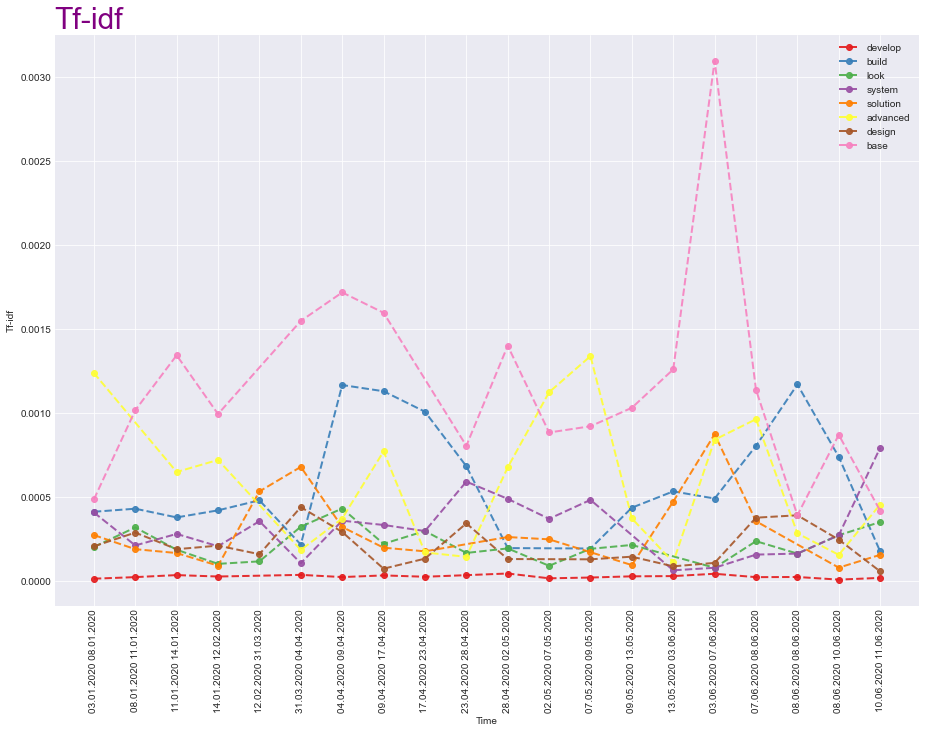

In [31]:
crate_graph("Tf-idf",tf_idf_tab)

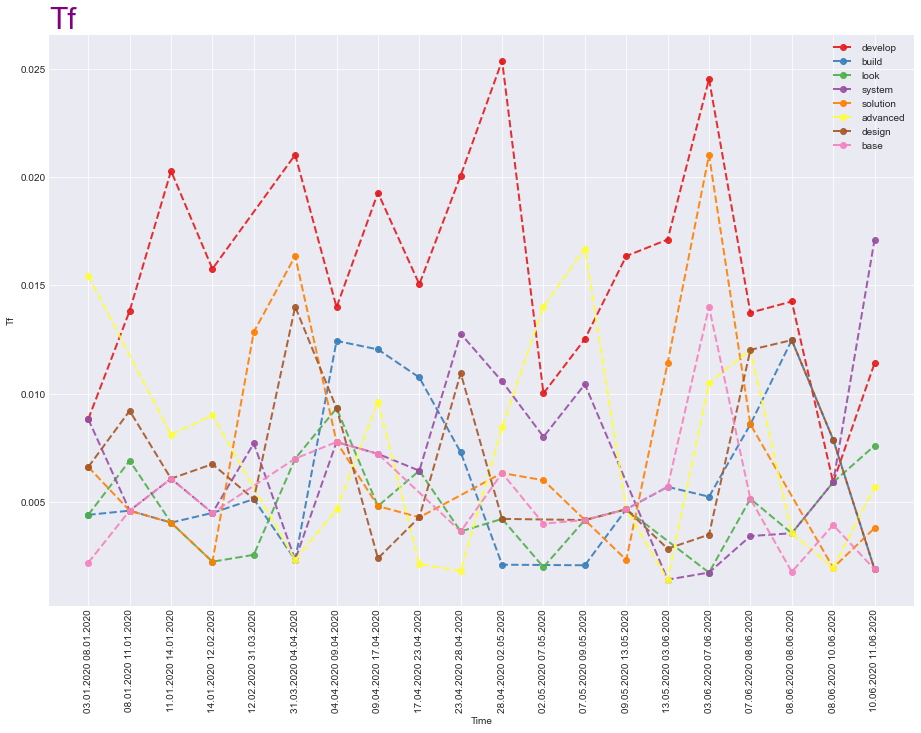

In [32]:
crate_graph("Tf",tf_tab)

## **Create vectors for tf idf**

In [33]:
def Create_dictionary_tf_idf(tf_idf_list):
    '''
    A function that receives a list of dictionaries for the tf-idf values of all the ads documents
    The function creates a dictionary with a list of tf-idf values for all documents
    '''
    dict_tf_idf_word_vectors = {
        key: [document.get(key) for document in tf_idf_list]
        for key in set().union(*tf_idf_list)
    }
    for key,values_list in dict_tf_idf_word_vectors.items():
        dict_tf_idf_word_vectors[key]=[0.0 if x==None else x for x in values_list]
    return dict_tf_idf_word_vectors


In [34]:
def remove_none_vector(dict_tf_idf_word_vectors,tf_idf_list):
    '''
    A function that extends words whose list values are zero
    '''
    none_list={}
    for key, value in dict_tf_idf_word_vectors.items():
        if value==[0.0]*len(tf_idf_list):
            none_list[key]=value
    dict_tf_idf_word_vectors={k: v for k, v in dict_tf_idf_word_vectors.items() if k not in none_list}
    return dict_tf_idf_word_vectors

In [35]:
def create_df_word_vectors(tf_idf_list,title):
    '''
    A function gets a list of dictionaries and a column name.
    The function returns a data frame
    '''
    dict_tf_idf_word_vectors=remove_none_vector(Create_dictionary_tf_idf(tf_idf_list),tf_idf_list)
    # Convert a dictionary of lists to tuple
    Tf_idf_word_vectors=[(key,value) for key, value in dict_tf_idf_word_vectors.items()]
    return pd.DataFrame(Tf_idf_word_vectors, columns=['word',title])

In [36]:
# Create word vectors for the original tf-idf values
df_word_vectors=create_df_word_vectors(tf_idf_list,'tf-idf')

In [37]:
df_word_vectors[(df_word_vectors['word']=='c++') | (df_word_vectors['word']=='c') | (df_word_vectors['word']=='python') ]

,word,tf-idf
1169,c++,"[0.0, 0.0, 0.0009565216486319976, 0.0031862511..."
9281,c,"[0.0, 0.0, 0.0012000489751841548, 0.0026649736..."
11252,python,"[0.0006271374803538901, 0.00032729640391741035..."


In [38]:
len(df_word_vectors)

11856

# Word2vec

In [39]:
def wordvec_input(word, glove_vectors ):
    '''
    A function that accepts as a global vector word argument.
    Function that returns a word2vec word vector when the word is in the global vector, otherwise returns a zero vector.
    '''
    try:
        vector = glove_vectors.wv[word]
    except KeyError:
        vector = np.zeros(25)
    return vector 

In [40]:
# # Download the "glove-twitter-25" embeddings - load glove vectors
glove_vectors = gensim.downloader.load('glove-twitter-25')

In [41]:
def create_word2vec_vector(df_word_vectors):
    '''
    A function that accepts a data frame as an argument and inserts a vector word2vec into it.
    '''
    # # Download the "glove-twitter-25" embeddings - load glove vectors
    glove_vectors = gensim.downloader.load('glove-twitter-25')
    # Create word2vec dataframe
    df_word2vec=pd.DataFrame(df_word_vectors['word'])
    # Call to function wordvec_input
    df_word2vec['wordvec'] = df_word_vectors['word'].apply(lambda x: wordvec_input(x, glove_vectors))
    # change type wordvec col
    df_word2vec['wordvec']=df_word2vec['wordvec'].apply(list)
    #marge 2 dataframes
    df_word2vec=pd.merge(df_word_vectors, df_word2vec, on=("word"))
    return df_word2vec

In [42]:
df_word2vec= create_word2vec_vector(df_word_vectors)

<ipython-input-39-36156baff54d>:7: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  vector = glove_vectors.wv[word]


In [43]:
df_word2vec.head()

,word,tf-idf,wordvec
0,every_day,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0014640547259...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,repurpose,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.36971, 0.12273, -0.64815, 1.102, -0.37973,..."
2,deep_ecosystem_industry,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,assuring,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-1.0532, 0.44871, -0.88903, 1.529, -0.44923, ..."
4,high_tolerance,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [44]:
# Create a v3 representation by adding word2vec vector values to the tf-idf vector values for each word
df_word2vec["combine_vectors"] = df_word2vec["tf-idf"] + df_word2vec["wordvec"]

In [45]:
# Change column type
df_word2vec["combine_vectors"]=df_word2vec["combine_vectors"].apply(list)

In [46]:
df_word2vec[(df_word2vec['word']=='c++') | (df_word2vec['word']=='c') | (df_word2vec['word']=='python') ]

,word,tf-idf,wordvec,combine_vectors
1169,c++,"[0.0, 0.0, 0.0009565216486319976, 0.0031862511...","[0.29033, 0.42036, -0.77658, -0.19994, 1.014, ...","[0.0, 0.0, 0.0009565216486319976, 0.0031862511..."
9281,c,"[0.0, 0.0, 0.0012000489751841548, 0.0026649736...","[0.42345, -0.29531, -0.74547, -0.37288, -0.268...","[0.0, 0.0, 0.0012000489751841548, 0.0026649736..."
11252,python,"[0.0006271374803538901, 0.00032729640391741035...","[-0.25645, -0.22323, 0.025901, 0.22901, 0.4902...","[0.0006271374803538901, 0.00032729640391741035..."


In [47]:
# Save the original tf-idf vector and word2vec data in the file
df_word2vec.to_csv(url+'df_word_vectors.csv',index=False)

# Normalization tf
tf= Value tf for each word in the document

tf_max = Maximum tf value in the document

alpha=0.4

new_tf=alpha+((1-alpha)*(tf/tf_max))

In [47]:
# Find the maximum value and key of tf in each document
maximum_tf_list=[[max((tf_list[document]).items(),key=operator.itemgetter(1))[0], max(tf_list[document].values())] for document in range(len(tf_list))]

In [48]:
# For each document the maximum tf value, Several documents=699
pd.DataFrame(maximum_tf_list).rename(columns={0:'word',1:'max_value_tf'})

,word,max_value_tf
0,experience,0.019868
1,experience,0.016129
2,experience,0.024341
3,engineer,0.020270
4,ml,0.023136
...,...,...
694,experience,0.025316
695,train,0.023256
696,experience,0.027202
697,experience,0.025260


In [49]:
# Function calculator normalizes tf values for all documents
def normalization_tf(tf_list, maximum_tf_list):
    '''
    normalization tf function
    A function that receives a list of lists that contains the tf values for all the ad documents, 
    and a list of the maximum tf values for each document.
    Returns a list of lists that contain the tf values after normalization for all ads documents.
    '''
    alpha=0.4
    new_tf_for_all_documents=[]
    for tf_dict_per_doc, tf_max in zip(tf_list,maximum_tf_list):
        new_tf_for_single_document=[]
                                    #tf[0]=word_name,tf[1]=tf_value, tf_max[1]=max_tf
        # For each word in each document the new tf value is calculated
        new_tf_for_single_document=[(tf[0],alpha+((1-alpha)*(tf[1]/tf_max[1]))) for tf in tf_dict_per_doc.items()]
        
        new_tf_for_all_documents.append(dict(new_tf_for_single_document))
        
    # Returns an array that contains all the tf values for all documents
    return new_tf_for_all_documents


In [50]:
# Create a tf after normalization
new_tf_for_all_documents=normalization_tf(tf_list, maximum_tf_list )

In [51]:
# Calculate tf-idf for normalized tf values
tf_idf_list_after_normalize=calculate_tf_idf(new_tf_for_all_documents,idf_list, listWordDict)

In [52]:
# Create word vectors for the normalized values of tf-idf
df_word_vectors_after_normalize=create_df_word_vectors(tf_idf_list_after_normalize,'tf-idf_after_norm')

In [53]:
df_all_data_tf_idf=df_word_vectors

In [54]:
# Create a data frame that contains all the types of tf-idf vectors calculated - original and normalized vectors
df_all_data_tf_idf.insert(2,'tf-idf_after_norm', df_word_vectors_after_normalize['tf-idf_after_norm'])

In [56]:
# Save all tf-idf vector data in a file
df_all_data_tf_idf.to_csv(url+'df_word_vectors_normalize.csv',index=False)

In [57]:
df_all_data_tf_idf.shape

(11856, 3)

In [55]:
df_all_data_tf_idf[(df_all_data_tf_idf['word']=='c++') | (df_all_data_tf_idf['word']=='c') | (df_all_data_tf_idf['word']=='python') ]

,word,tf-idf,tf-idf_after_norm
1169,c++,"[0.0, 0.0, 0.0009565216486319976, 0.0031862511...","[0.0, 0.0, 0.21220432774900866, 0.282939103665..."
9281,c,"[0.0, 0.0, 0.0012000489751841548, 0.0026649736...","[0.0, 0.0, 0.26623086514460476, 0.315532877208..."
11252,python,"[0.0006271374803538901, 0.00032729640391741035...","[0.07575820762674992, 0.0689940819457901, 0.07..."
